# Predicting Units of Product Sold

## Business Understanding

Understanding the demand of products is one of the most difficult problems for all businesses that produce physical goods. Even understanding the demand of a single product marketed to a single consumer base can be extremely challenging work. This challenge is compounded when dealing with the variety of products in the variety of markets that Wal-Mart is involved in. Developing a generalizable model that can be used to understand demand could give Wal-Mart a significant competitive edge over competition. An important factors that allowed Wal-Mart to keep its prices competitive and consolidate so many markets was its efficient supply chain. [Profitworks](https://profitworks.ca/small-business-sales-and-marketing-resources/blog/marketing-strategy/579-sam-walton-wal-mart-what-is-wal-mart-s-secret-to-success.html), a marketing agency, credits one of the largest reasons for Wal-Mart's national success as its extremely efficient supply chain. Being able to accurately forecast demand is imperative to efficiently running a supply chain whose supply can consistently meet demand without having an excessive amount of inventory. Keeping all products available and properly managing inventory can be difficult, and it becomes exponentially more difficult when storage bins are cluttered and/or full. Managing this balance, especially in stores with less space for inventory such as Wal-Mart Neighborhood Markets, can demand high levels of precision. 

## Data Understanding

The data used in this analysis can be found from the M5 Forecasting - Accuracy competition on Kaggle. It contains a 5 files: calendar.csv, sales_train_validation.csv, sample_submission.csv, sell_prices.csv, and sales_train_evaluation.csv. The calendar.csv file contains the date for every day, as well as the weekday, month, and Wal-Mart week. It also includes information of the days holiday status, and the days when snap is available. The sales_train_validation.csv contains information on the amount of units sold every day for 3019 different products across 10 different Wal-Mart stores in three different states. The sales_train_evaluation data contains the same information as the validation data, along with the correct values for the 28 day forecast. The sample_submission.csv contains an example csv for the format needed to submit the 28 day forecasts. The sell_prices.csv contains the prices at which the items were sold for every Wal-Mart week.

In [1]:
# imports for notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

### Dates Data

In [2]:
# read in the dates and their recorded unique characteristics
dates = pd.read_csv('C:/Users/TWood/Downloads/m5-forecasting-accuracy/calendar.csv', parse_dates=[0])

In [3]:
# take a look at the dates df
dates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1969 non-null   datetime64[ns]
 1   wm_yr_wk      1969 non-null   int64         
 2   weekday       1969 non-null   object        
 3   wday          1969 non-null   int64         
 4   month         1969 non-null   int64         
 5   year          1969 non-null   int64         
 6   d             1969 non-null   object        
 7   event_name_1  162 non-null    object        
 8   event_type_1  162 non-null    object        
 9   event_name_2  5 non-null      object        
 10  event_type_2  5 non-null      object        
 11  snap_CA       1969 non-null   int64         
 12  snap_TX       1969 non-null   int64         
 13  snap_WI       1969 non-null   int64         
dtypes: datetime64[ns](1), int64(7), object(6)
memory usage: 215.5+ KB


In [4]:
# most days have no event, replace NaN with "None"
dates.replace(np.NaN, 'None', inplace=True)

#### Binarizing Events Columns

Some days have multiple events. One hot encoding will not be able to represent columns with multiple events, so the information will need to be in a format that the MultiLabelBinarizer can use. I'll make a new column that contains a list of all events on a given day. 

In [5]:
# remove spaces from all the events names
dates['event_name_1'] = dates['event_name_1'].str.replace(' ', '')
dates['event_name_2'] = dates['event_name_2'].str.replace(' ', '')

In [6]:
# create event column that contains a string of both events with a space between
dates['event'] = dates['event_name_1'] + ' ' + dates['event_name_2']

In [7]:
# split will turn the string into a list of both events
dates['event'] = dates['event'].str.split()

In [8]:
# removes the second element from the list when it is None
dates['event'] = dates['event'].apply(lambda x: [x[0]] if x[1] == 'None' else x)

In [9]:
# instantiat the MultiLabelBinarizer and fit it to the event column
mlb = MultiLabelBinarizer()
mlb.fit(dates['event'])
values = pd.DataFrame(mlb.transform(dates['event']), columns=mlb.classes_)

In [10]:
# adds the encoded columns to the dates dataframe
dates = pd.concat([dates, values], axis=1)

In [11]:
# drops the redundant event columns from dates
dates.drop(columns=['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'event'], inplace=True)

In [12]:
# instantiate the OneHotEncoder and fit it to weekday and month columns
ohe = OneHotEncoder(sparse=False)
ohe.fit(dates[['weekday', 'month']])
values = ohe.transform(dates[['weekday', 'month']])
values = pd.DataFrame(values, columns=ohe.get_feature_names())

In [13]:
# add the one hot encoded columns to the dates dataframe
dates = pd.concat([dates, values], axis=1)

In [14]:
# drop the unnecessary columns from the dates dataframe
dates.drop(columns=['wday', 'year', 'month', 'weekday', 'snap_WI', 'snap_TX'], inplace=True)

### Units Sold Data

This csv contains much more information than the calendar csv, and it is still in a wide format. It will need to be melted to be used in the model, and once this dataframe is merged with the other two dataframes, it will take up a huge amount of RAM. In order to work with the data on a computer with only 8GB of RAM, I've limited the data to only the Foods 1 department of the first California store. I'll provide notebooks for other stores and departments in the modeling folder on the repository.

In [15]:
# read in the data for units sold
val = pd.read_csv('C:/Users/TWood/Downloads/m5-forecasting-accuracy/sales_train_validation.csv')

In [16]:
# select only the data from department FOODS_1 in store CA_1 
CA1_F1 = val[(val['store_id'] == 'CA_1')&(val['dept_id'] == 'FOODS_1')]

In [17]:
# reducing the unnecessary columns to make the melt faster
CA1_F1.drop(columns=['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], inplace=True)

C:\Users\TWood\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [18]:
# convert the dataframe into long format
CA1_F1_ts = CA1_F1.melt(id_vars=['id'], var_name='d', value_name='sales')

### Prices Data

In [19]:
# read in the data on the prices for the products
prices = pd.read_csv('C:/Users/TWood/Downloads/m5-forecasting-accuracy/sell_prices.csv')

In [20]:
# make a new id column that matches the format of the id column in CA1_F1_ts
prices['id'] = prices['item_id'] + '_' + prices['store_id'] + '_validation'

## Modeling DataFrame

The 

In [21]:
# create a dataframe with the information from all dataframes
CA1_F1_price = CA1_F1_ts.merge(dates, on='d').merge(prices.drop(columns=['store_id', 'item_id']), on=['id', 'wm_yr_wk'], how='left')

In [22]:
# set the index of the dataframe to the date column
CA1_F1_price.set_index('date', inplace=True)

#### Missing Prices

There are several missing prices in the dataframe, which could cause a big problem when modeling. However, upon further inspection, there were always zero sales of a product when it the products price was missing. This suggests that the price was not entered for these weeks because it was not on the shelves for those weeks. The weeks where the price is missing can easily be dropped when fitting the model as they will not be representative of the actual demand of the product. Furthermore, all 30490 distinct ids are present during the last week 11621, which means that every product in every store was on the shelf. If any of these prices were missing, it would be best to remove these predictions from the model. 

In [23]:
# there are several nulls after left joining with prices
CA1_F1_price['sell_price'].isna().sum()

61292

In [24]:
# there are never any sales of a product when its price is missing for the week
((CA1_F1_price['sales'] == 0)&(CA1_F1_price['sell_price'].isna())).sum()

61292

In [25]:
# 30490 total items
len(val)

30490

In [26]:
# the sell prices are present for all 30490 items for the final week, matches length of val dataframe
(prices['wm_yr_wk'] == 11621).sum()

30490

#### Lag Columns

This lag column will tell the model how many units were sold 28 days earlier. In order for this model to be maximally useful, Wal-Mart will need to be able to predict sales of an item much further than a week before hand. My original model contained several more lags from within 28 days, but was unable to predict days further out. It could be used to predict the next day accurately, but had a serious data leakage issue when forecasting more than one day out, as it used lags that a real model would not have access to. One could create a model that forecasts one day at a time replacing the lags with forecasted lags, but the model would suffer from giving too much weight to the forecasted lags that contain inherent error. I decided only to use lags outside of the range of the forecast. The lag of 28 will also be used to create the baseline model, where the prediction will be the amount of units sold 28 days before. I also made a column that gives the average sales of all the lags which are all the same day of the week. 

In [27]:
# make an iterable array of all the unique ids 
items = CA1_F1['id'].unique()
# there are 216 unique items in the dataframe
len(items)

216

In [28]:
# period will be 216 items * n days
CA1_F1_price['lag_28'] = CA1_F1_price['sales'].shift(periods=216*28)
CA1_F1_price['lag_35'] = CA1_F1_price['sales'].shift(periods=216*35)
CA1_F1_price['lag_42'] = CA1_F1_price['sales'].shift(periods=216*42)
CA1_F1_price['lag_49'] = CA1_F1_price['sales'].shift(periods=216*49)

In [29]:
# creates a column 
CA1_F1_price['avg'] = (CA1_F1_price['lag_28'] + CA1_F1_price['lag_35'] + CA1_F1_price['lag_42'] + CA1_F1_price['lag_49'])/4

In [30]:
# drops observations with missing values
CA1_F1_price.dropna(inplace=True)

In [31]:
# converts the d variable into an integer
CA1_F1_price['d'] = CA1_F1_price['d'].str.replace('d_', '').astype(int)

In [32]:
CA1_F1_price

,id,d,sales,wm_yr_wk,snap_CA,ChanukahEnd,Christmas,CincoDeMayo,ColumbusDay,Easter,...,x1_9,x1_10,x1_11,x1_12,sell_price,lag_28,lag_35,lag_42,lag_49,avg
date,,,,,,,,,,,,,,,,,,,,,
2011-03-19,FOODS_1_001_CA_1_validation,50,1,11108,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,2.00,1.0,3.0,2.0,3.0,2.25
2011-03-19,FOODS_1_002_CA_1_validation,50,1,11108,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,7.88,0.0,0.0,0.0,0.0,0.00
2011-03-19,FOODS_1_003_CA_1_validation,50,3,11108,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,2.88,2.0,1.0,1.0,0.0,1.00
2011-03-19,FOODS_1_005_CA_1_validation,50,2,11108,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,2.94,1.0,6.0,2.0,3.0,3.00
2011-03-19,FOODS_1_006_CA_1_validation,50,2,11108,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.97,5.0,8.0,1.0,0.0,3.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-24,FOODS_1_215_CA_1_validation,1913,0,11613,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.84,0.0,0.0,0.0,5.0,1.25
2016-04-24,FOODS_1_216_CA_1_validation,1913,1,11613,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,5.28,0.0,2.0,1.0,2.0,1.25
2016-04-24,FOODS_1_217_CA_1_validation,1913,3,11613,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,3.54,2.0,3.0,5.0,2.0,3.00


## Baseline Models

A common way to make baseline models for time series analysis is to calculate a lag over a certain period. As the goal is to forecast sales 28 days out, the lag_28 column for the last 28 days of the time series will be used as a baseline prediction. This gives an average RMSE of 2.06 between all the different products. There is also a baseline model that predicts units sold as the average amount of units sold daily for that item. This gives a better average RMSE of 1.71. A deployable model will need to greatly outperform both of these baseline models.

In [32]:
# make an empty list of preds and trues to add to
preds = []
trues = []
# loop through the CA1_F1_price df by item
for item in items:
    ts = CA1_F1_price[CA1_F1_price['id'] == item]
    # select only the last 28 days
    test = ts['2016-03-28':]
    # actual sales for every
    trues.append(test['sales'])
    # the predictions will be the number of sales 28 days before
    preds.append(test['lag_28'])

In [33]:
# empty list that will contain all the RMSEs
RMSEs = []
# there will be 216 arrays of preds and trues
for i in range(216):
    RMSEs.append(mean_squared_error(trues[i], preds[i], squared=False))

In [34]:
# calculate the average RMSE for the baseline model
np.mean(RMSEs)

2.0627187993990534

In [35]:
# make a new list of preds
preds = []
# get the average number of units sold for every item
for item in items:
    ts = CA1_F1_price[CA1_F1_price['id'] == item]
    train = ts[:'2016-03-28']
    test = ts['2016-03-28':]
    # add a list with the average 28 times
    preds.append([train['sales'].mean()]*28)

In [36]:
# empty list that will contain all the RMSEs
RMSEs = []
# there will be 216 arrays of preds and trues
for i in range(216):
    RMSEs.append(mean_squared_error(trues[i], preds[i], squared=False))

In [37]:
# average RMSE for baseline model
np.mean(RMSEs)

1.7120488074490898

## First Model

Random Forest Models are often a good place to begin when searching for a good model. They are extremely flexible and often give pretty good results even without hyperparemeter tuning. They also run much faster than many more complex models. In fact they are often quicker than simpler models such as K-Nearest Neighbors. This model ended up seriously overfitting and had an average coefficient of determination below negative one on testing data. It did get an RMSE of 1.83, which beats the first baseline of 2.06, but fails to outperform the second baseline of 1.71. Significant improvement is needed to make this model actually worth implementing. Also, strangely enough, this Random Forest model was actually much slower than the Extreme Gradient Boosted model. The Random Forest algorithm will be left behind as it does not seem to be appropriate for this sort of problem. 

In [38]:
# make a list of all the columns columns
cols = CA1_F1_price.drop(columns=['id', 'sales']).columns

In [41]:
# instantiate empty lists
preds = []
train_scores = []
test_scores = []
importances = []
# loop through every item
for item in items:
    # create a time series only including intended item
    ts = CA1_F1_price[CA1_F1_price['id'] == item].drop(columns=['id'])
    # remove last 28 days from training data
    train = ts[:'2016-03-28']
    test = ts['2016-03-28':]
    # split into X and y
    X_train = train.drop('sales', axis=1)
    X_test = test.drop('sales', axis=1)
    y_train = train['sales']
    y_test = test['sales']
    # instantiate a RandomForestRegressor and fit to training
    rf = RandomForestRegressor(random_state=42).fit(X_train, y_train)
    # add predictions to the list
    preds.append(rf.predict(X_test))
    # .score methods are important for evaluating whether model is overfit
    train_scores.append(rf.score(X_train, y_train))
    test_scores.append(rf.score(X_test, y_test))
    # retrieve importances from model
    importances.append(dict(zip(cols, rf.feature_importances_)))

In [42]:
# mean R-squared of .87
np.mean(train_scores)

0.8702285775343062

In [43]:
# massively overfit
np.mean(test_scores)

-0.9795491960207451

In [46]:
# function to return average RMSE of all 216 models
def get_rmse():
    RMSEs = []
    for i in range(216):
        RMSEs.append(mean_squared_error(trues[i], preds[i], squared=False))
    return np.mean(RMSEs)

In [47]:
# use function for average RMSE
get_rmse()

1.8335955133316726

In [48]:
# helper function to return dictionary of importances
def get_imp():
    feat_imp = []
    for col in cols:
        nums = []
        for imp in importances:
            nums.append(imp[col])
        feat_imp.append(np.mean(nums))
    return dict(zip(cols, feat_imp))

In [51]:
# use function for importances
get_imp()

{'d': 0.2839337527263052,
 'wm_yr_wk': 0.09841299182976755,
 'snap_CA': 0.022267399457546657,
 'ChanukahEnd': 0.0018633630042057406,
 'Christmas': 0.0003120854394019062,
 'CincoDeMayo': 0.0006420301881387592,
 'ColumbusDay': 0.0008681355667154263,
 'Easter': 0.001688124002863015,
 'EidAlAdha': 0.0012810098594773255,
 'Eidal-Fitr': 0.0010614525800370634,
 "Father'sday": 0.0009243128545181596,
 'Halloween': 0.002317013231742939,
 'IndependenceDay': 0.0010059111788702313,
 'LaborDay': 0.0014614947527288185,
 'LentStart': 0.0019241985076988025,
 'LentWeek2': 0.0007898917634785533,
 'MartinLutherKingDay': 0.0012374370164390986,
 'MemorialDay': 0.0010447899991037264,
 "Mother'sday": 0.0008945560526338063,
 'NBAFinalsEnd': 0.0012209487351802469,
 'NBAFinalsStart': 0.0008801079101222549,
 'NewYear': 0.0004836528078570807,
 'None': 0.005231828029658608,
 'OrthodoxChristmas': 0.0008589387237576967,
 'OrthodoxEaster': 0.0009725928201508303,
 'PesachEnd': 0.0010046641671613826,
 'PresidentsDay': 0

## XGBoost

Extreme Gradient Boost(XGBoost) is one of the most popular modern machine learning algorithms. It is a common winner of machine learning competitions and has been shown effictive in a vast range of domains. Even using the default arguments of the XGBoost algorithm can often give strong results, and these results can improve greatly when the hyperparameters are tuned. As mentioned earlier, this algorithm, unexpectedly, ran faster than the Random Forest algorithm. However, the results of this model was even worse than the first model with an average RMSE of 1.97, which was almost as bad as the first baseline model. It was also even more overfit than the first model, so the hyperparameters will need to be heavily tuned to get more value out of this.

In [52]:
preds = []
train_scores = []
test_scores = []
importances = []
for item in items:
    ts = CA1_F1_price[CA1_F1_price['id'] == item].drop(columns=['id'])
    train = ts[:'2016-03-28']
    test = ts['2016-03-28':]
    X_train = train.drop('sales', axis=1)
    X_test = test.drop('sales', axis=1)
    y_train = train['sales']
    y_test = test['sales']
    xgb = XGBRegressor(random_state=42).fit(X_train, y_train)
    preds.append(xgb.predict(X_test))
    train_scores.append(xgb.score(X_train, y_train))
    test_scores.append(xgb.score(X_test, y_test))
    # retrieve importances from model
    importances.append(dict(zip(cols, xgb.feature_importances_)))

In [53]:
np.mean(train_scores)

0.9160606916245376

In [54]:
np.mean(test_scores)

-1.1666935250261343

In [55]:
# return average RMSE
get_rmse()

1.9671867585832188

In [56]:
# return dict of importances
get_imp()

{'d': 0.028999506,
 'wm_yr_wk': 0.0,
 'snap_CA': 0.020771552,
 'ChanukahEnd': 0.011113732,
 'Christmas': 0.011568806,
 'CincoDeMayo': 0.0077653164,
 'ColumbusDay': 0.007399521,
 'Easter': 0.011954689,
 'EidAlAdha': 0.009162884,
 'Eidal-Fitr': 0.010208428,
 "Father'sday": 0.0086688455,
 'Halloween': 0.014120667,
 'IndependenceDay': 0.009725765,
 'LaborDay': 0.01041976,
 'LentStart': 0.011618274,
 'LentWeek2': 0.0064562056,
 'MartinLutherKingDay': 0.008294864,
 'MemorialDay': 0.007927818,
 "Mother'sday": 0.0074857497,
 'NBAFinalsEnd': 0.008588989,
 'NBAFinalsStart': 0.007066576,
 'NewYear': 0.0061026835,
 'None': 0.015455146,
 'OrthodoxChristmas': 0.008311892,
 'OrthodoxEaster': 0.007233133,
 'PesachEnd': 0.007116974,
 'PresidentsDay': 0.006952669,
 'PurimEnd': 0.008307666,
 'Ramadanstarts': 0.0082113715,
 'StPatricksDay': 0.008119483,
 'SuperBowl': 0.008140992,
 'Thanksgiving': 0.00529331,
 'ValentinesDay': 0.015003409,
 'VeteransDay': 0.008113549,
 'x0_Friday': 0.019287957,
 'x0_Monday

### XGBoost Model 2

Tweedie loss is supposed to be good for distributions with a high proportion of zeros, and the results suggest that this was a great choice. While this model still needs a lot of improvement, now it is at least almost on par with the better baseline model. It is much less overfit to the training data now, but still needs some more regularization.

In [58]:
preds = []
train_scores = []
test_scores = []
importances = []
for item in items:
    ts = CA1_F1_price[CA1_F1_price['id'] == item].drop(columns=['id'])
    train = ts[:'2016-03-28']
    test = ts['2016-03-28':]
    X_train = train.drop('sales', axis=1)
    X_test = test.drop('sales', axis=1)
    y_train = train['sales']
    y_test = test['sales']
    xgb2 = XGBRegressor(random_state=42, objective='reg:tweedie').fit(X_train, y_train)
    preds.append(xgb2.predict(X_test))
    train_scores.append(xgb2.score(X_train, y_train))
    test_scores.append(xgb2.score(X_test, y_test))
    # retrieve importances from model
    importances.append(dict(zip(cols, xgb2.feature_importances_)))

In [59]:
np.mean(train_scores)

0.8717568262817005

In [60]:
np.mean(test_scores)

-0.567660937689128

In [61]:
# return average RMSE
get_rmse()

1.7303743696414524

In [62]:
# return dict of importances
get_imp()

{'d': 0.032245345,
 'wm_yr_wk': 0.0,
 'snap_CA': 0.018353257,
 'ChanukahEnd': 0.008309086,
 'Christmas': 0.041004755,
 'CincoDeMayo': 0.00761557,
 'ColumbusDay': 0.007632049,
 'Easter': 0.008010554,
 'EidAlAdha': 0.0071339705,
 'Eidal-Fitr': 0.0067807976,
 "Father'sday": 0.0071282764,
 'Halloween': 0.009651025,
 'IndependenceDay': 0.007888835,
 'LaborDay': 0.008188605,
 'LentStart': 0.008128597,
 'LentWeek2': 0.008507379,
 'MartinLutherKingDay': 0.008708451,
 'MemorialDay': 0.007198242,
 "Mother'sday": 0.006291358,
 'NBAFinalsEnd': 0.008213843,
 'NBAFinalsStart': 0.006708238,
 'NewYear': 0.008775971,
 'None': 0.01692668,
 'OrthodoxChristmas': 0.007967221,
 'OrthodoxEaster': 0.0065033026,
 'PesachEnd': 0.007103803,
 'PresidentsDay': 0.0065225544,
 'PurimEnd': 0.00682425,
 'Ramadanstarts': 0.0067189755,
 'StPatricksDay': 0.006816915,
 'SuperBowl': 0.009677587,
 'Thanksgiving': 0.0109921275,
 'ValentinesDay': 0.008592926,
 'VeteransDay': 0.0073011825,
 'x0_Friday': 0.016288713,
 'x0_Monda

### XGBoost Model 3

Regularization really helped the model reduce overfitting. While there was a huge improvement, the model is still very overfit. However, the RMSE has reached 1.54, which is finally outperforming both of the baseline models. The model still has a negative coefficient of determination, which is suggests a lot of improvement can be made.

In [68]:
preds = []
train_scores = []
test_scores = []
importances = []
for item in items:
    ts = CA1_F1_price[CA1_F1_price['id'] == item].drop(columns=['id'])
    train = ts[:'2016-03-28']
    test = ts['2016-03-28':]
    X_train = train.drop('sales', axis=1)
    X_test = test.drop('sales', axis=1)
    y_train = train['sales']
    y_test = test['sales']
    xgb3 = XGBRegressor(random_state=42, objective='reg:tweedie', reg_alpha=5, reg_lambda=5).fit(X_train, y_train)
    preds.append(xgb3.predict(X_test))
    train_scores.append(xgb3.score(X_train, y_train))
    test_scores.append(xgb3.score(X_test, y_test))
    # retrieve importances from model
    importances.append(dict(zip(cols, xgb3.feature_importances_)))

In [69]:
np.mean(train_scores)

0.6785659786853302

In [70]:
np.mean(test_scores)

-0.23296383638873552

In [71]:
# return average RMSE
get_rmse()

1.544304111249151

In [72]:
# return dict of importances
get_imp()

{'d': 0.048945446,
 'wm_yr_wk': 0.0,
 'snap_CA': 0.01736595,
 'ChanukahEnd': 0.00917954,
 'Christmas': 0.0445314,
 'CincoDeMayo': 0.0064787115,
 'ColumbusDay': 0.00869104,
 'Easter': 0.008074566,
 'EidAlAdha': 0.007102828,
 'Eidal-Fitr': 0.007302305,
 "Father'sday": 0.0074213357,
 'Halloween': 0.011037641,
 'IndependenceDay': 0.009694539,
 'LaborDay': 0.007946148,
 'LentStart': 0.0098119965,
 'LentWeek2': 0.010197224,
 'MartinLutherKingDay': 0.009844167,
 'MemorialDay': 0.006403624,
 "Mother'sday": 0.0067767864,
 'NBAFinalsEnd': 0.008240353,
 'NBAFinalsStart': 0.008824067,
 'NewYear': 0.010218617,
 'None': 0.0136310505,
 'OrthodoxChristmas': 0.009041794,
 'OrthodoxEaster': 0.008102555,
 'PesachEnd': 0.006269693,
 'PresidentsDay': 0.00785955,
 'PurimEnd': 0.005988788,
 'Ramadanstarts': 0.008404157,
 'StPatricksDay': 0.008972239,
 'SuperBowl': 0.010187066,
 'Thanksgiving': 0.011262764,
 'ValentinesDay': 0.008954936,
 'VeteransDay': 0.007698416,
 'x0_Friday': 0.014063126,
 'x0_Monday': 0.

### XGBoost Model 4

The default max_depth for XGBoost is 3, and generally it is recommended to stay below 10. Typically a max depth of 4-8 is the best parameter for XGBoost, as you need the trees to be weak predictors. I tried reducing the max depth in order to reduce overfit, but it ended up causing underfit. Then I tried increasing the max_depth and bumping up regularization to combat overfitting. This seemed to result in overfit that regularization could not deal with. Increasing regularization did have a good effect, however the max_depth of 3 resulted in the best average RMSE. The RMSE was reduced to 1.47, but the model still has a negative coefficient of determination. Much progress will need to be made before this model is worth deploying. There seems to be too much noise to fit these models, or just as likely, there are too many important variables this model is missing.

In [120]:
preds = []
train_scores = []
test_scores = []
importances = []
for item in items:
    ts = CA1_F1_price[CA1_F1_price['id'] == item].drop(columns=['id'])
    train = ts[:'2016-03-28']
    test = ts['2016-03-28':]
    X_train = train.drop('sales', axis=1)
    X_test = test.drop('sales', axis=1)
    y_train = train['sales']
    y_test = test['sales']
    xgb4 = XGBRegressor(random_state=42, objective='reg:tweedie', max_depth=3, reg_alpha=25, reg_lambda=25).fit(X_train, y_train)
    preds.append(xgb4.predict(X_test))
    train_scores.append(xgb4.score(X_train, y_train))
    test_scores.append(xgb4.score(X_test, y_test))
    # retrieve importances from model
    importances.append(dict(zip(cols, xgb4.feature_importances_)))

In [124]:
np.mean(train_scores)

0.225347435583728

In [125]:
np.mean(test_scores)

-0.14892255326148632

In [126]:
# return average RMSE
get_rmse()

1.4742527782295138

In [127]:
# return dict of importances
get_imp()

{'d': 0.11453462,
 'wm_yr_wk': 0.0,
 'snap_CA': 0.012602516,
 'ChanukahEnd': 0.0016057836,
 'Christmas': 0.02925956,
 'CincoDeMayo': 0.0022497613,
 'ColumbusDay': 0.0014691772,
 'Easter': 0.0030411228,
 'EidAlAdha': 0.00084533653,
 'Eidal-Fitr': 0.0017338111,
 "Father'sday": 0.001687361,
 'Halloween': 0.0037634578,
 'IndependenceDay': 0.00334487,
 'LaborDay': 0.0019199215,
 'LentStart': 0.0036812099,
 'LentWeek2': 0.0033802043,
 'MartinLutherKingDay': 0.003780982,
 'MemorialDay': 0.0029031632,
 "Mother'sday": 0.001209296,
 'NBAFinalsEnd': 0.0015547634,
 'NBAFinalsStart': 0.0026609357,
 'NewYear': 0.0039238436,
 'None': 0.011955236,
 'OrthodoxChristmas': 0.0030862705,
 'OrthodoxEaster': 0.0007089753,
 'PesachEnd': 0.0013257692,
 'PresidentsDay': 0.001485105,
 'PurimEnd': 0.00061066664,
 'Ramadanstarts': 0.0031482803,
 'StPatricksDay': 0.0026736204,
 'SuperBowl': 0.0021859144,
 'Thanksgiving': 0.008025706,
 'ValentinesDay': 0.0006093484,
 'VeteransDay': 0.001459612,
 'x0_Friday': 0.01749

## LGBM Model

Light gradient boosted machine algorithms are designed to work on the same principals as XGB, but work even faster. Many of the top models in the M5-Accuracy competition used the LGBM algorithm. The default arguments of the LGBM gave much better results than the default XGBoost algorithm.

In [163]:
preds = []
train_scores = []
test_scores = []
importances = []
for item in items:
    ts = CA1_F1_price[CA1_F1_price['id'] == item].drop(columns=['id'])
    train = ts[:'2016-03-28']
    test = ts['2016-03-28':]
    X_train = train.drop('sales', axis=1)
    X_test = test.drop('sales', axis=1)
    y_train = train['sales']
    y_test = test['sales']
    lgbm = LGBMRegressor(random_state=42).fit(X_train, y_train)
    preds.append(lgbm.predict(X_test))
    train_scores.append(lgbm.score(X_train, y_train))
    test_scores.append(lgbm.score(X_test, y_test))
    # retrieve importances from model
    importances.append(dict(zip(cols, lgbm.feature_importances_)))

In [164]:
np.mean(train_scores)

0.6231491889099577

In [165]:
np.mean(test_scores)

-0.3385652572298986

In [166]:
# return average RMSE
get_rmse()

1.5794216034649093

In [167]:
# return dict of importances
get_imp()

{'d': 919.4861111111111,
 'wm_yr_wk': 332.1296296296296,
 'snap_CA': 83.68518518518519,
 'ChanukahEnd': 0.0,
 'Christmas': 0.0,
 'CincoDeMayo': 0.0,
 'ColumbusDay': 0.0,
 'Easter': 0.0,
 'EidAlAdha': 0.0,
 'Eidal-Fitr': 0.0,
 "Father'sday": 0.0,
 'Halloween': 0.0,
 'IndependenceDay': 0.0,
 'LaborDay': 0.0,
 'LentStart': 0.0,
 'LentWeek2': 0.0,
 'MartinLutherKingDay': 0.0,
 'MemorialDay': 0.0,
 "Mother'sday": 0.0,
 'NBAFinalsEnd': 0.0,
 'NBAFinalsStart': 0.0,
 'NewYear': 0.0,
 'None': 24.435185185185187,
 'OrthodoxChristmas': 0.0,
 'OrthodoxEaster': 0.0,
 'PesachEnd': 0.0,
 'PresidentsDay': 0.0,
 'PurimEnd': 0.0,
 'Ramadanstarts': 0.0,
 'StPatricksDay': 0.0,
 'SuperBowl': 0.0,
 'Thanksgiving': 0.0,
 'ValentinesDay': 0.0,
 'VeteransDay': 0.0,
 'x0_Friday': 33.43981481481482,
 'x0_Monday': 28.5,
 'x0_Saturday': 40.907407407407405,
 'x0_Sunday': 34.5,
 'x0_Thursday': 26.930555555555557,
 'x0_Tuesday': 27.833333333333332,
 'x0_Wednesday': 26.21759259259259,
 'x1_1': 17.291666666666668,
 'x1

### LGBM Model 2

In [168]:
preds = []
train_scores = []
test_scores = []
importances = []
for item in items:
    ts = CA1_F1_price[CA1_F1_price['id'] == item].drop(columns=['id'])
    train = ts[:'2016-03-28']
    test = ts['2016-03-28':]
    X_train = train.drop('sales', axis=1)
    X_test = test.drop('sales', axis=1)
    y_train = train['sales']
    y_test = test['sales']
    lgbm2 = LGBMRegressor(random_state=42, objective='tweedie').fit(X_train, y_train)
    preds.append(lgbm2.predict(X_test))
    train_scores.append(lgbm2.score(X_train, y_train))
    test_scores.append(lgbm2.score(X_test, y_test))
    # retrieve importances from model
    importances.append(dict(zip(cols, lgbm2.feature_importances_)))

In [169]:
np.mean(train_scores)

0.6920178372604975

In [170]:
np.mean(test_scores)

-0.2980829367034139

In [171]:
# return average RMSE
get_rmse()

1.5667547227755494

In [172]:
# return dict of importances
get_imp()

{'d': 948.1342592592592,
 'wm_yr_wk': 375.61574074074076,
 'snap_CA': 89.11111111111111,
 'ChanukahEnd': 0.0,
 'Christmas': 0.0,
 'CincoDeMayo': 0.0,
 'ColumbusDay': 0.0,
 'Easter': 0.0,
 'EidAlAdha': 0.0,
 'Eidal-Fitr': 0.0,
 "Father'sday": 0.0,
 'Halloween': 0.0,
 'IndependenceDay': 0.0,
 'LaborDay': 0.0,
 'LentStart': 0.0,
 'LentWeek2': 0.0,
 'MartinLutherKingDay': 0.0,
 'MemorialDay': 0.0,
 "Mother'sday": 0.0,
 'NBAFinalsEnd': 0.0,
 'NBAFinalsStart': 0.0,
 'NewYear': 0.0,
 'None': 26.72685185185185,
 'OrthodoxChristmas': 0.0,
 'OrthodoxEaster': 0.0,
 'PesachEnd': 0.0,
 'PresidentsDay': 0.0,
 'PurimEnd': 0.0,
 'Ramadanstarts': 0.0,
 'StPatricksDay': 0.0,
 'SuperBowl': 0.0,
 'Thanksgiving': 0.0,
 'ValentinesDay': 0.0,
 'VeteransDay': 0.0,
 'x0_Friday': 37.61574074074074,
 'x0_Monday': 34.31481481481482,
 'x0_Saturday': 42.38425925925926,
 'x0_Sunday': 38.513888888888886,
 'x0_Thursday': 33.03703703703704,
 'x0_Tuesday': 35.495370370370374,
 'x0_Wednesday': 33.52777777777778,
 'x1_1':

### LGBM Model 3

In [173]:
preds = []
train_scores = []
test_scores = []
importances = []
for item in items:
    ts = CA1_F1_price[CA1_F1_price['id'] == item].drop(columns=['id'])
    train = ts[:'2016-03-28']
    test = ts['2016-03-28':]
    X_train = train.drop('sales', axis=1)
    X_test = test.drop('sales', axis=1)
    y_train = train['sales']
    y_test = test['sales']
    lgbm3 = LGBMRegressor(random_state=42, objective='tweedie', max_depth=3).fit(X_train, y_train)
    preds.append(lgbm3.predict(X_test))
    train_scores.append(lgbm3.score(X_train, y_train))
    test_scores.append(lgbm3.score(X_test, y_test))
    # retrieve importances from model
    importances.append(dict(zip(cols, lgbm3.feature_importances_)))

In [174]:
np.mean(train_scores)

0.3173486254893772

In [175]:
np.mean(test_scores)

-0.22673440194569652

In [176]:
# return average RMSE
get_rmse()

1.529020861241018

In [177]:
# return dict of importances
get_imp()

{'d': 179.78703703703704,
 'wm_yr_wk': 89.13425925925925,
 'snap_CA': 14.319444444444445,
 'ChanukahEnd': 0.0,
 'Christmas': 0.0,
 'CincoDeMayo': 0.0,
 'ColumbusDay': 0.0,
 'Easter': 0.0,
 'EidAlAdha': 0.0,
 'Eidal-Fitr': 0.0,
 "Father'sday": 0.0,
 'Halloween': 0.0,
 'IndependenceDay': 0.0,
 'LaborDay': 0.0,
 'LentStart': 0.0,
 'LentWeek2': 0.0,
 'MartinLutherKingDay': 0.0,
 'MemorialDay': 0.0,
 "Mother'sday": 0.0,
 'NBAFinalsEnd': 0.0,
 'NBAFinalsStart': 0.0,
 'NewYear': 0.0,
 'None': 5.847222222222222,
 'OrthodoxChristmas': 0.0,
 'OrthodoxEaster': 0.0,
 'PesachEnd': 0.0,
 'PresidentsDay': 0.0,
 'PurimEnd': 0.0,
 'Ramadanstarts': 0.0,
 'StPatricksDay': 0.0,
 'SuperBowl': 0.0,
 'Thanksgiving': 0.0,
 'ValentinesDay': 0.0,
 'VeteransDay': 0.0,
 'x0_Friday': 8.101851851851851,
 'x0_Monday': 6.916666666666667,
 'x0_Saturday': 13.703703703703704,
 'x0_Sunday': 10.023148148148149,
 'x0_Thursday': 5.62037037037037,
 'x0_Tuesday': 8.26388888888889,
 'x0_Wednesday': 6.787037037037037,
 'x1_1': 

### LGBM Model 4

In [178]:
preds = []
train_scores = []
test_scores = []
importances = []
for item in items:
    ts = CA1_F1_price[CA1_F1_price['id'] == item].drop(columns=['id'])
    train = ts[:'2016-03-28']
    test = ts['2016-03-28':]
    X_train = train.drop('sales', axis=1)
    X_test = test.drop('sales', axis=1)
    y_train = train['sales']
    y_test = test['sales']
    lgbm4 = LGBMRegressor(random_state=42, objective='tweedie', max_depth=3, reg_alpha=10, reg_lambda=10).fit(X_train, y_train)
    preds.append(lgbm4.predict(X_test))
    train_scores.append(lgbm4.score(X_train, y_train))
    test_scores.append(lgbm4.score(X_test, y_test))
    # retrieve importances from model
    importances.append(dict(zip(cols, lgbm4.feature_importances_)))

In [179]:
np.mean(train_scores)

0.24732014727022897

In [180]:
np.mean(test_scores)

-0.16713719880589933

In [181]:
# return average RMSE
get_rmse()

1.4738177095328013

In [182]:
# return dict of importances
get_imp()

{'d': 190.91666666666666,
 'wm_yr_wk': 95.9675925925926,
 'snap_CA': 10.069444444444445,
 'ChanukahEnd': 0.0,
 'Christmas': 0.0,
 'CincoDeMayo': 0.0,
 'ColumbusDay': 0.0,
 'Easter': 0.0,
 'EidAlAdha': 0.0,
 'Eidal-Fitr': 0.0,
 "Father'sday": 0.0,
 'Halloween': 0.0,
 'IndependenceDay': 0.0,
 'LaborDay': 0.0,
 'LentStart': 0.0,
 'LentWeek2': 0.0,
 'MartinLutherKingDay': 0.0,
 'MemorialDay': 0.0,
 "Mother'sday": 0.0,
 'NBAFinalsEnd': 0.0,
 'NBAFinalsStart': 0.0,
 'NewYear': 0.0,
 'None': 4.041666666666667,
 'OrthodoxChristmas': 0.0,
 'OrthodoxEaster': 0.0,
 'PesachEnd': 0.0,
 'PresidentsDay': 0.0,
 'PurimEnd': 0.0,
 'Ramadanstarts': 0.0,
 'StPatricksDay': 0.0,
 'SuperBowl': 0.0,
 'Thanksgiving': 0.0,
 'ValentinesDay': 0.0,
 'VeteransDay': 0.0,
 'x0_Friday': 7.935185185185185,
 'x0_Monday': 6.180555555555555,
 'x0_Saturday': 15.5,
 'x0_Sunday': 10.99537037037037,
 'x0_Thursday': 4.962962962962963,
 'x0_Tuesday': 7.939814814814815,
 'x0_Wednesday': 5.523148148148148,
 'x1_1': 5.430555555555

### LGBM Model 5

In [201]:
preds = []
train_scores = []
test_scores = []
importances = []
for item in items:
    ts = CA1_F1_price[CA1_F1_price['id'] == item].drop(columns=['id'])
    train = ts[:'2016-03-28']
    test = ts['2016-03-28':]
    X_train = train.drop('sales', axis=1)
    X_test = test.drop('sales', axis=1)
    y_train = train['sales']
    y_test = test['sales']
    lgbm5 = LGBMRegressor(random_state=42, objective='tweedie', num_leaves=64, max_depth=6, reg_alpha=20, reg_lambda=20).fit(X_train, y_train)
    preds.append(lgbm5.predict(X_test))
    train_scores.append(lgbm5.score(X_train, y_train))
    test_scores.append(lgbm5.score(X_test, y_test))
    # retrieve importances from model
    importances.append(dict(zip(cols, lgbm5.feature_importances_)))

In [202]:
np.mean(train_scores)

0.24443125477495545

In [203]:
np.mean(test_scores)

-0.18778630355894385

In [204]:
# return average RMSE
get_rmse()

1.471088475091799

In [192]:
# return dict of importances
get_imp()

{'d': 426.9861111111111,
 'wm_yr_wk': 246.82407407407408,
 'snap_CA': 8.689814814814815,
 'ChanukahEnd': 0.0,
 'Christmas': 0.0,
 'CincoDeMayo': 0.0,
 'ColumbusDay': 0.0,
 'Easter': 0.0,
 'EidAlAdha': 0.0,
 'Eidal-Fitr': 0.0,
 "Father'sday": 0.0,
 'Halloween': 0.0,
 'IndependenceDay': 0.0,
 'LaborDay': 0.0,
 'LentStart': 0.0,
 'LentWeek2': 0.0,
 'MartinLutherKingDay': 0.0,
 'MemorialDay': 0.0,
 "Mother'sday": 0.0,
 'NBAFinalsEnd': 0.0,
 'NBAFinalsStart': 0.0,
 'NewYear': 0.0,
 'None': 4.226851851851852,
 'OrthodoxChristmas': 0.0,
 'OrthodoxEaster': 0.0,
 'PesachEnd': 0.0,
 'PresidentsDay': 0.0,
 'PurimEnd': 0.0,
 'Ramadanstarts': 0.0,
 'StPatricksDay': 0.0,
 'SuperBowl': 0.0,
 'Thanksgiving': 0.0,
 'ValentinesDay': 0.0,
 'VeteransDay': 0.0,
 'x0_Friday': 11.13888888888889,
 'x0_Monday': 8.5,
 'x0_Saturday': 24.12037037037037,
 'x0_Sunday': 13.935185185185185,
 'x0_Thursday': 6.597222222222222,
 'x0_Tuesday': 10.393518518518519,
 'x0_Wednesday': 7.87962962962963,
 'x1_1': 7.759259259259

## Final Model

While XGBoost achieved better numbers for the coefficient of determination, the LGBM models had better RMSEs. I decided to choose this LGBM model because it is faster than the XGBoost model and the RMSE is the metric I value more. Despite this being my final model, there is still a lot of improvement that needs to be made before it is of much value. For one, I never 

In [238]:
preds = []
train_scores = []
test_scores = []
importances = []
for item in items:
    ts = CA1_F1_price[CA1_F1_price['id'] == item].drop(columns=['id'])
    train = ts[:'2016-03-28']
    test = ts['2016-03-28':]
    X_train = train.drop('sales', axis=1)
    X_test = test.drop('sales', axis=1)
    y_train = train['sales']
    y_test = test['sales']
    lgbm6 = LGBMRegressor(random_state=42, n_estimators=500, objective='tweedie', max_depth=8, num_leaves=64, reg_alpha=22, reg_lambda=22).fit(X_train, y_train)
    preds.append(lgbm6.predict(X_test))
    train_scores.append(lgbm6.score(X_train, y_train))
    test_scores.append(lgbm6.score(X_test, y_test))
    # retrieve importances from model
    importances.append(dict(zip(cols, lgbm6.feature_importances_)))

In [239]:
np.mean(train_scores)

0.24061940543395086

In [240]:
np.mean(test_scores)

-0.1855647671614698

In [221]:
# return average RMSE
get_rmse()

1.463227842223587

In [226]:
# return dict of importances
feat_importance = get_imp()
feat_importance

{'d': 503.6388888888889,
 'wm_yr_wk': 318.31944444444446,
 'snap_CA': 9.087962962962964,
 'ChanukahEnd': 0.0,
 'Christmas': 0.0,
 'CincoDeMayo': 0.0,
 'ColumbusDay': 0.0,
 'Easter': 0.0,
 'EidAlAdha': 0.0,
 'Eidal-Fitr': 0.0,
 "Father'sday": 0.0,
 'Halloween': 0.0,
 'IndependenceDay': 0.0,
 'LaborDay': 0.0,
 'LentStart': 0.0,
 'LentWeek2': 0.0,
 'MartinLutherKingDay': 0.0,
 'MemorialDay': 0.0,
 "Mother'sday": 0.0,
 'NBAFinalsEnd': 0.0,
 'NBAFinalsStart': 0.0,
 'NewYear': 0.0,
 'None': 6.037037037037037,
 'OrthodoxChristmas': 0.0,
 'OrthodoxEaster': 0.0,
 'PesachEnd': 0.0,
 'PresidentsDay': 0.0,
 'PurimEnd': 0.0,
 'Ramadanstarts': 0.0,
 'StPatricksDay': 0.0,
 'SuperBowl': 0.0,
 'Thanksgiving': 0.0,
 'ValentinesDay': 0.0,
 'VeteransDay': 0.0,
 'x0_Friday': 11.75462962962963,
 'x0_Monday': 8.708333333333334,
 'x0_Saturday': 27.708333333333332,
 'x0_Sunday': 19.203703703703702,
 'x0_Thursday': 6.708333333333333,
 'x0_Tuesday': 10.430555555555555,
 'x0_Wednesday': 9.310185185185185,
 'x1_1'

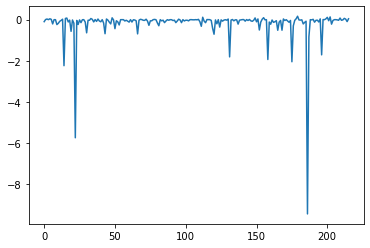

In [223]:
plt.plot(test_scores)

In [252]:
imp_graph = dict(sorted(feat_importance.items(), key=lambda item: item[1], reverse=True)[:10])

In [267]:
sns.set_palette(sns.color_palette("light:b"))

<AxesSubplot:>

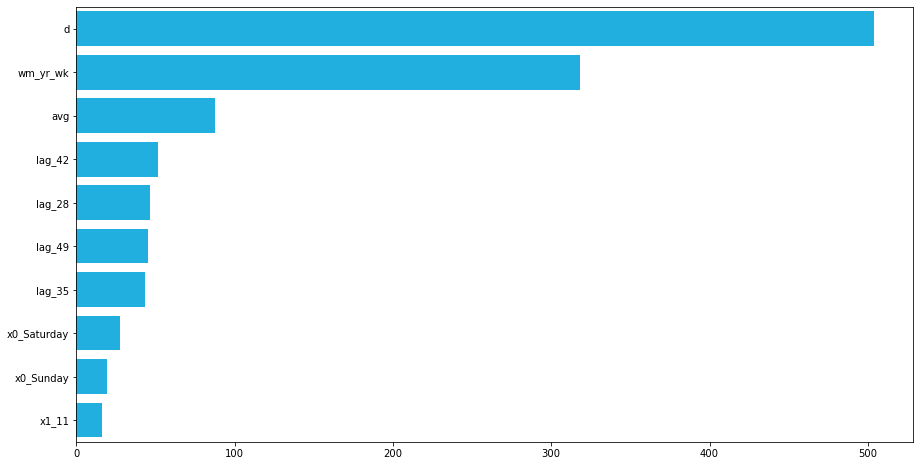

In [277]:
fig, ax = plt.subplots(figsize=(15,8))
sns.barplot(x=list(imp_graph.values()), y=list(imp_graph.keys()), color='deepskyblue', ax=ax)

## Thoughts

- need to take into account different types of items, if you're selling Christmas items after Christmas for a reduced price, does it actually reflect the demand of the product
- need to take into account marketing, end-caps, and how close to eye-level the products, how do these effect demand
- need to take into account inventory, sometimes something has high demand but lack of inventory fails to reflect the full demand, like Oatly milk.
- need to talk about the skepticism of just in time manufacturing and how this could change this. 